# Exploring Pokémon Battles with atoti

This notebook explores the Pokémon data from Kaggle in an [OLAP](https://en.wikipedia.org/wiki/Online_analytical_processing) cube created using [atoti](https://www.atoti.io/):  
- [Tuan Nguyen Van Anh's Pokémon Dataset with Team Combat](https://www.kaggle.com/tuannguyenvananh/pokemon-dataset-with-team-combat)  
- [Mario Tormo Romero's Complete Pokémon Dataset](https://www.kaggle.com/mariotormo/complete-pokemon-dataset-updated-090420).

I will demonstrate how I can create a analytics platform end-to-end:
- Preprocessing: processing data prior to data loading into the cube
- Measure creation: creating KPIs for the story
- Data visualization: creating visualizations in Jupyter notebook during data modelling stage
- Dashboarding: complete storytelling with dashboards using atoti web application

Bonus:  
Using the __atoti-plus__ plugin, I have also extended the atoti web application to create custom widgets.  
The custom widget will invoke the [custom endpoints](https://docs.atoti.io/latest/lib/atoti.session.html#atoti.session.Session.endpoint) to simulate random battles.  
__Note: Atoti+ is the enterprise version of atoti.__

In [1]:
import datetime as dt
import urllib
from datetime import date

import atoti as tt
import numpy as np
import pandas as pd

## 1. Data preprocessing

atoti can read from various datasources including Pandas. I will make use of Pandas to clean up my data and perform some low level computations before loading data into atoti.

### 1.1 Pokémon stats data

Before looking at each battle, let's understand the Pokémon a little more. Using Pandas, I renamed the columns into a friendlier convention.  

Since __atoti will automatically inherit the data type from the DataFrame__, I will cast the data type for the Pandas DataFrame column accordingly.    
For instance, the `Pokedex` column is inferred as `int` by Pandas but I want it to be treated as a `String`. So let's cast it explicitly.

In [2]:
pokemon_df = pd.read_csv(
    "https://data.atoti.io/notebooks/pokemon/pokemon.csv",
    header=0,
    names=[
        "Pokedex",
        "Generation",
        "Pokemon",
        "JP Name",
        "Primary Type",
        "Secondary Type",
        "Classification",
        "Percentage Male",
        "Percentage Female",
        "Height",
        "Weight",
        "Capture Rate",
        "Base Egg Steps",
        "HP",
        "Attack",
        "Defense",
        "SP Attack",
        "SP Defense",
        "Speed",
        "Sub-Legendary",
        "Legendary",
        "Mythical",
    ],
    dtype={"Pokedex": str},
)

pokemon_df.head()

,Pokedex,Generation,Pokemon,JP Name,Primary Type,Secondary Type,Classification,Percentage Male,Percentage Female,Height,...,Base Egg Steps,HP,Attack,Defense,SP Attack,SP Defense,Speed,Sub-Legendary,Legendary,Mythical
0,1,I,Bulbasaur,Fushigidane,grass,poison,Seed,88.14,11.86,0.7,...,5120,45,49,49,65,65,45,0,0,0
1,2,I,Ivysaur,Fushigisou,grass,poison,Seed,88.14,11.86,1.0,...,5120,60,62,63,80,80,60,0,0,0
2,3,I,Venusaur,Fushigibana,grass,poison,Seed,88.14,11.86,2.0,...,5120,80,82,83,100,100,80,0,0,0
3,4,I,Charmander,Hitokage,fire,NaN,Lizard,88.14,11.86,0.6,...,5120,39,52,43,60,50,65,0,0,0
4,5,I,Charmeleon,Lizardo,fire,NaN,Flame,88.14,11.86,1.1,...,5120,58,64,58,80,65,80,0,0,0


I want to combine the 3 columns-`Sub-Legendary`, `Legendary` and `Mythical` into a boolean column `(Sub)Legendary or Mythical` and drop the columns that are not being used.

In [3]:
pokemon_df["(Sub)Legendary or Mythical"] = False
pokemon_df.loc[
    (pokemon_df["Sub-Legendary"] == 1)
    | (pokemon_df["Legendary"] == 1)
    | (pokemon_df["Mythical"] == 1),
    "(Sub)Legendary or Mythical",
] = True

In [4]:
pokemon_df.drop(
    columns=[
        "Sub-Legendary",
        "Legendary",
        "Mythical",
        "JP Name",
        "Primary Type",
        "Secondary Type",
    ],
    inplace=True,
)

pokemon_df.head()

,Pokedex,Generation,Pokemon,Classification,Percentage Male,Percentage Female,Height,Weight,Capture Rate,Base Egg Steps,HP,Attack,Defense,SP Attack,SP Defense,Speed,(Sub)Legendary or Mythical
0,1,I,Bulbasaur,Seed,88.14,11.86,0.7,6.9,45,5120,45,49,49,65,65,45,False
1,2,I,Ivysaur,Seed,88.14,11.86,1.0,13.0,45,5120,60,62,63,80,80,60,False
2,3,I,Venusaur,Seed,88.14,11.86,2.0,100.0,45,5120,80,82,83,100,100,80,False
3,4,I,Charmander,Lizard,88.14,11.86,0.6,8.5,45,5120,39,52,43,60,50,65,False
4,5,I,Charmeleon,Flame,88.14,11.86,1.1,19.0,45,5120,58,64,58,80,65,80,False


### 1.2 Pokémon's combat data

This dataset gives information on each battle such as the battling Pokémon, the battle results and the number of views.  
Using Pandas, I've renamed the columns during the read of the combats.csv file and cast the IDs to `String`.

In [5]:
combat_df = pd.read_csv(
    "https://data.atoti.io/notebooks/pokemon/combats.csv",
    header=0,
    names=[
        "Registration ID",
        "Combat ID",
        "Pokemon ID",
        "Opponent Pokemon ID",
        "Result",
        "Type Multiplier",
        "Replay Views",
        "Live Views (Start - End)",
    ],
    dtype={
        "Registration ID": str,
        "Combat ID": str,
        "Pokemon ID": str,
        "Opponent Pokemon ID": str,
    },
)

combat_df.head()

,Registration ID,Combat ID,Pokemon ID,Opponent Pokemon ID,Result,Type Multiplier,Replay Views,Live Views (Start - End)
0,1,1,266,298,losE,0.5,29629,15306;1664
1,2,1,298,266,WIn,1.0,109229,83732;75822
2,3,2,702,701,LOSE,2.0,27634,4533;2656
3,4,2,701,702,WIN,0.5,82359,9983;40424
4,5,3,191,668,LOSE,0.5,71664,54796;16377


The `Result` column is of random casing. Let's set the column values to a standardized casing, uppercase i.

In [6]:
combat_df["Result"] = combat_df["Result"].str.upper()
combat_df.head()

,Registration ID,Combat ID,Pokemon ID,Opponent Pokemon ID,Result,Type Multiplier,Replay Views,Live Views (Start - End)
0,1,1,266,298,LOSE,0.5,29629,15306;1664
1,2,1,298,266,WIN,1.0,109229,83732;75822
2,3,2,702,701,LOSE,2.0,27634,4533;2656
3,4,2,701,702,WIN,0.5,82359,9983;40424
4,5,3,191,668,LOSE,0.5,71664,54796;16377


I split the `Live Views (Start - End)` column by the delimiter `;` to get the viewership at the start and the end of the combat.

In [7]:
combat_df[["Live Views Start", "Live Views End"]] = combat_df[
    "Live Views (Start - End)"
].str.split(";", 1, expand=True)
combat_df[["Live Views Start", "Live Views End"]] = combat_df[
    ["Live Views Start", "Live Views End"]
].astype(int)

combat_df.head()

,Registration ID,Combat ID,Pokemon ID,Opponent Pokemon ID,Result,Type Multiplier,Replay Views,Live Views (Start - End),Live Views Start,Live Views End
0,1,1,266,298,LOSE,0.5,29629,15306;1664,15306,1664
1,2,1,298,266,WIN,1.0,109229,83732;75822,83732,75822
2,3,2,702,701,LOSE,2.0,27634,4533;2656,4533,2656
3,4,2,701,702,WIN,0.5,82359,9983;40424,9983,40424
4,5,3,191,668,LOSE,0.5,71664,54796;16377,54796,16377


Using Pandas, I will compute the rate of change in views from the start to the end of the battle. This could also be done in the cube using atoti's aggregation functions. However, as these statistics at the granular level will not change, computing it before loading into the cube will save some computation resources at query time (atoti computes on the fly).

In [8]:
combat_df["Live Views Change"] = (
    combat_df["Live Views End"] - combat_df["Live Views Start"]
) / combat_df["Live Views Start"]
combat_df.head()

,Registration ID,Combat ID,Pokemon ID,Opponent Pokemon ID,Result,Type Multiplier,Replay Views,Live Views (Start - End),Live Views Start,Live Views End,Live Views Change
0,1,1,266,298,LOSE,0.5,29629,15306;1664,15306,1664,-0.891284
1,2,1,298,266,WIN,1.0,109229,83732;75822,83732,75822,-0.094468
2,3,2,702,701,LOSE,2.0,27634,4533;2656,4533,2656,-0.414075
3,4,2,701,702,WIN,0.5,82359,9983;40424,9983,40424,3.049284
4,5,3,191,668,LOSE,0.5,71664,54796;16377,54796,16377,-0.701128


Since I have the number of live views at the start and end of the battle, I will drop the column `Live Views (Start - End)`.

In [9]:
combat_df.drop(columns=["Live Views (Start - End)"], inplace=True)

## 2. Datasets used for simulations  
Later on in the use case, I will be performing some what-if simulations by modifying some data:
- Number of tickets sold in `Combat info` dataset

While atoti is able to load CSV directly into its table, here I'm going to load the data into Pandas DataFrame first.  
This is to facilitate data manipulation later on for the [source simulations](https://docs.atoti.io/latest/tutorial/tutorial.html#Source-simulation) at the end of the notebook.

### 2.1 Combat info   

This dataset gives the number of tickets sold for each combat and the date of the battle.  

In [10]:
dateparse = lambda x: dt.datetime.strptime(x, "%d/%m/%Y").date()

In [11]:
combat_info_df = pd.read_csv(
    "https://data.atoti.io/notebooks/pokemon/combatinfo.csv",
    parse_dates=["Date"],
    date_parser=dateparse,
    dtype={"Season": str, "Combat ID": str, "Location ID": str},
)

combat_info_df.head()

,Combat ID,Season,Location ID,Tickets Sold,Date
0,1,1,1,1959,3001-02-18
1,2,1,2,1921,3001-02-18
2,3,1,3,1936,3001-02-18
3,4,1,4,1737,3001-02-18
4,5,1,5,1971,3001-02-18


## 3. Getting started with atoti

Now that I have cleaned up our data, I can get started with atoti.  

### 3.0 Switching between atoti and Atoti+

<img src="https://data.atoti.io/notebooks/banners/atoti-atoti-plus-v3.png">  
Switch from atoti to Atoti+ by updating the below variable to `True`. 

In [12]:
atoti_plus_switch = False

By setting the above variable to `True`, I can leverage Atoti+ to use the below customized web application. Note, this requires installing the __[atoti-plus](https://docs.atoti.io/latest/lib/atoti-plus/atoti_plus.html#module-atoti_plus)__ plugin.  
Setting the above variable to `False` will continue to use atoti, no Atoti+ required.

<img src="custom_widgets.gif" width="700px"/>

Contact [support@atoti.io](mailto:support@atoti.io) regarding licensing if you want to try Atoti+.  

Below shows the Atoti+ configuration(s) applied in this use case.

In [13]:
plus_app_ext = (
    {"@atoti/pokemon-extension": "./extensions/dist"} if atoti_plus_switch else {}
)

Let's proceed with basic atoti and proceed to create an atoti session. 

### 3.1 Create atoti session
Using the [session configuration](https://docs.atoti.io/latest/lib/atoti.config.session_config.html#atoti.config.session_config.SessionConfig), I can:
1. fix the `port` that will be used by the atoti web application
2. create `user_content_storage` to save our dashboards. Otherwise, dashboards will be stored in transient memory and will be gone when the session is gone.

In [14]:
session = tt.Session(
    port=8080,
    user_content_storage="./content",
    app_extensions=plus_app_ext,  # {"@atoti/pokemon-extension": "./extensions/dist"},
)

### 3.2 Create atoti tables  

atoti can load data from a variety of datasources, such as CSV and Pandas Dataframe as demonstrated below.

In [15]:
type_t = session.read_csv(
    "s3://data.atoti.io/notebooks/pokemon/type_reg.csv",
    table_name="Types",
    keys=["ID"],
    types={"ID": tt.type.STRING, "Registration ID": tt.type.STRING},
)

type_t.head(3)

,Pokemon Type,Opponent Pokemon Type,Registration ID
ID,,,
161654,Psychic,Poison,91329
161655,Bug,Psychic,91330
161656,Poison,Psychic,91330


In [16]:
combat_t = session.read_pandas(
    combat_df,
    table_name="Combats",
    keys=["Registration ID"],
    types={
        "Replay Views": tt.type.LONG,
        "Live Views Change": tt.type.DOUBLE,
        "Live Views Start": tt.type.LONG,
        "Live Views End": tt.type.LONG,
    },
)

combat_t.head(3)

,Combat ID,Pokemon ID,Opponent Pokemon ID,Result,Type Multiplier,Replay Views,Live Views Start,Live Views End,Live Views Change
Registration ID,,,,,,,,,
1,1,266,298,LOSE,0.5,29629,15306,1664,-0.891284
2,1,298,266,WIN,1.0,109229,83732,75822,-0.094468
3,2,702,701,LOSE,2.0,27634,4533,2656,-0.414075


In [17]:
combat_info_t = session.read_pandas(
    combat_info_df, table_name="Combat Info", keys=["Combat ID"]
)

The location dataset gives detail to the location where the combats are held and the costs of hosting a battle.

In [18]:
location_t = session.read_csv(
    "s3://data.atoti.io/notebooks/pokemon/locations.csv",
    table_name="Locations",
    keys=["Location ID"],
    types={
        "Location ID": tt.type.STRING,
        "Stadium Cost": tt.type.DOUBLE,
        "Ticket Price": tt.type.DOUBLE,
    },
)

location_t.head(3)

,Region,Settlement,Stadium Cost,Ticket Price,Stadium Capacity
Location ID,,,,,
1,Alola,Iki Town,17000.0,15.0,2000
2,Unova,Mistralton City,24000.0,20.0,2000
3,Johto,Blackthorn City,22000.0,20.0,2000


I will load the Pokémon stats dataset into 2 separate tables as:
1. the battling Pokémon
2. the opponent Pokémon (columns renamed)

In [19]:
pokemon_t = session.read_pandas(pokemon_df, table_name="Pokemon", keys=["Pokedex"])
pokemon_t.head(3)

,Generation,Pokemon,Classification,Percentage Male,Percentage Female,Height,Weight,Capture Rate,Base Egg Steps,HP,Attack,Defense,SP Attack,SP Defense,Speed,(Sub)Legendary or Mythical
Pokedex,,,,,,,,,,,,,,,,
1,I,Bulbasaur,Seed,88.14,11.86,0.7,6.9,45,5120,45,49,49,65,65,45,False
2,I,Ivysaur,Seed,88.14,11.86,1.0,13.0,45,5120,60,62,63,80,80,60,False
3,I,Venusaur,Seed,88.14,11.86,2.0,100.0,45,5120,80,82,83,100,100,80,False


In [20]:
pokemon_df.columns = map(lambda n: "Opponent " + n, pokemon_df.columns)

In [21]:
o_pokemon_t = session.read_pandas(
    pokemon_df, table_name="Opponent Pokemon", keys=["Opponent Pokedex"]
)
o_pokemon_t.head(3)

,Opponent Generation,Opponent Pokemon,Opponent Classification,Opponent Percentage Male,Opponent Percentage Female,Opponent Height,Opponent Weight,Opponent Capture Rate,Opponent Base Egg Steps,Opponent HP,Opponent Attack,Opponent Defense,Opponent SP Attack,Opponent SP Defense,Opponent Speed,Opponent (Sub)Legendary or Mythical
Opponent Pokedex,,,,,,,,,,,,,,,,
1,I,Bulbasaur,Seed,88.14,11.86,0.7,6.9,45,5120,45,49,49,65,65,45,False
2,I,Ivysaur,Seed,88.14,11.86,1.0,13.0,45,5120,60,62,63,80,80,60,False
3,I,Venusaur,Seed,88.14,11.86,2.0,100.0,45,5120,80,82,83,100,100,80,False


### 3.3 Create multidimensional data cube  

Choose the data table with the most granular level data to be the base table for cube creation.

In [22]:
cube_name = "Pokemon battles"
cube = session.create_cube(type_t, name=cube_name)

### 3.4 Join referenced tables

I create joins between tables as show below. It is not necessary to specify the join mapping explicity if the column names are matching.  
atoti automatically infers the common columns as join mappings.

In [23]:
type_t.join(combat_t, mapping={"Registration ID": "Registration ID"})
combat_t.join(pokemon_t, mapping={"Pokemon ID": "Pokedex"})
combat_t.join(o_pokemon_t, mapping={"Opponent Pokemon ID": "Opponent Pokedex"})
combat_t.join(combat_info_t, mapping={"Combat ID": "Combat ID"})
combat_info_t.join(location_t, mapping={"Location ID": "Location ID"})

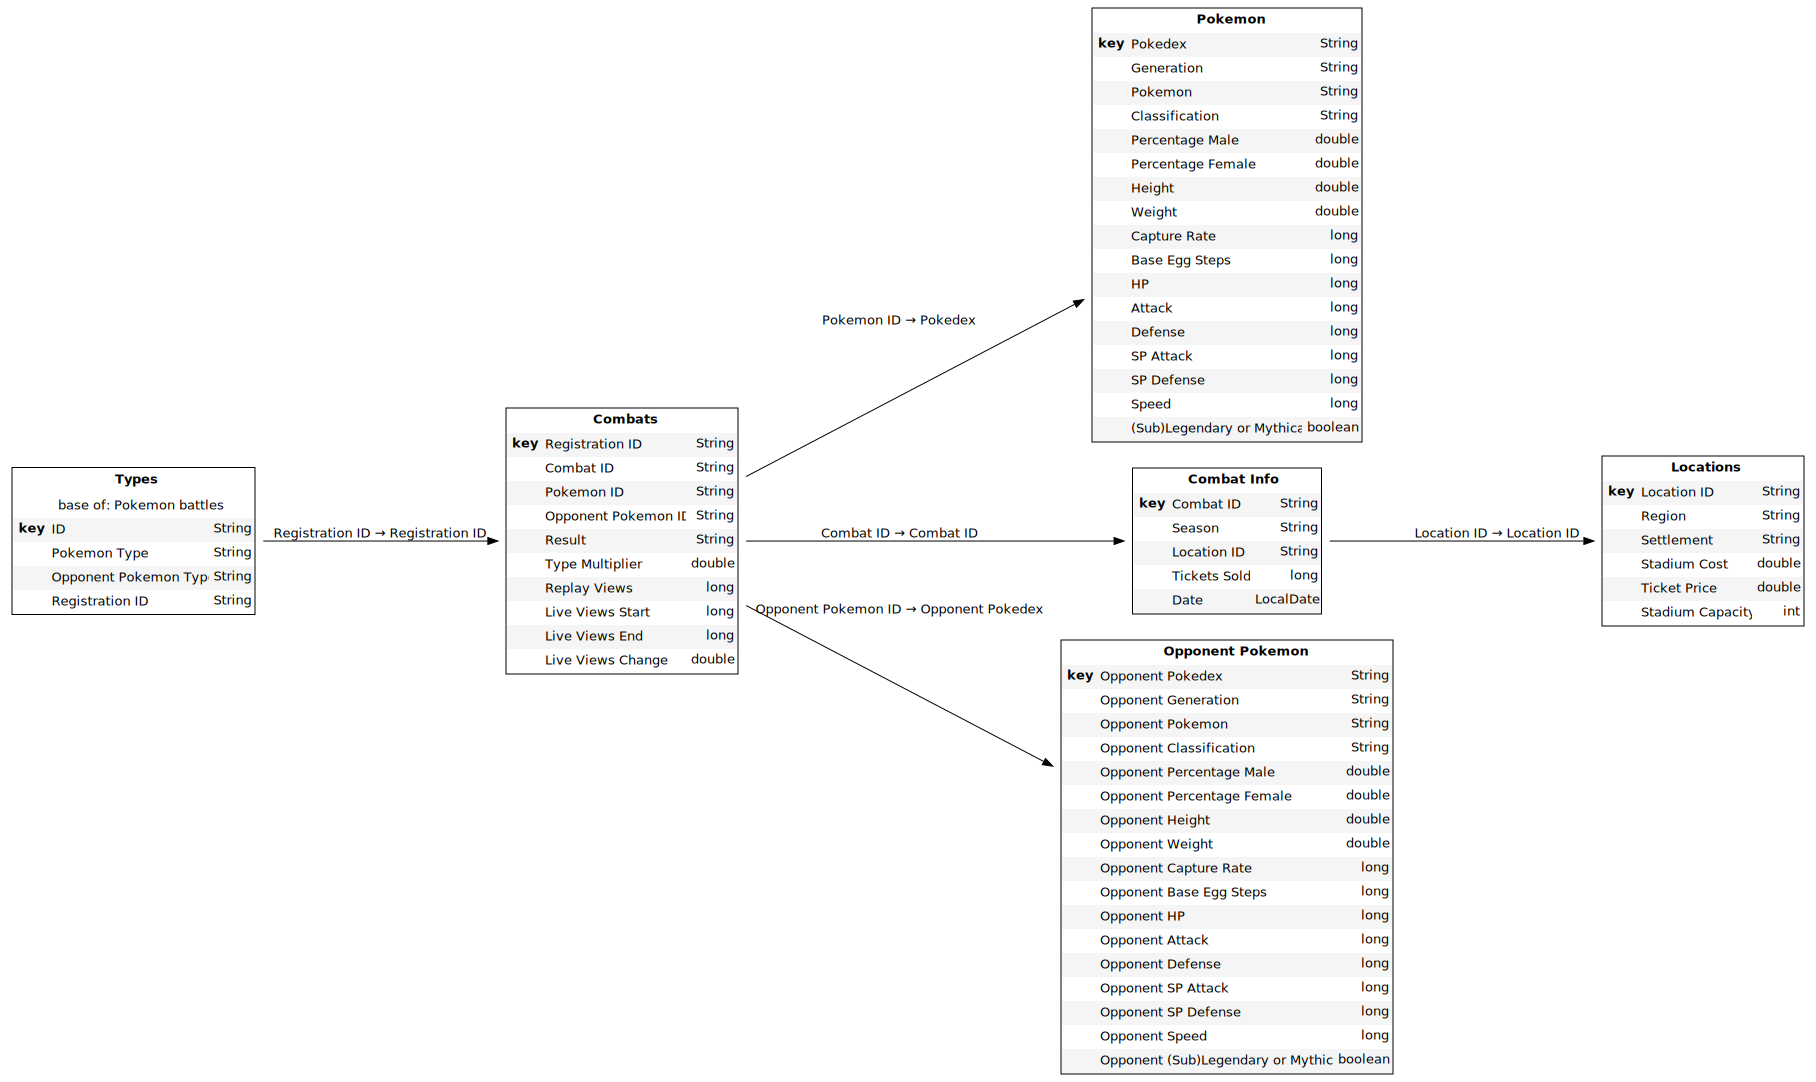

In [24]:
session.tables.schema

## 4. Cube manipulation 

Aliasing the cube attributes makes it easier to work with during measure creations and hierarchy manipulations.

In [25]:
h, m, l = cube.hierarchies, cube.measures, cube.levels

In [26]:
h

Hierarchies(_create_hierarchy_from_arguments=<bound method Cube._create_hierarchy_from_arguments of Cube(_name='Pokemon battles', _hierarchies=..., _measures=Measures())>, _cube_name='Pokemon battles')

In [27]:
m

Measures()

### 4.1 Hierarchy manipulation

Here I am going to clean up the hierarchies automatically created that I don't need, and create others.  
__Note:__ I can also [create the cube in `manual` mode](https://docs.atoti.io/latest/lib/atoti.session.html#atoti.session.Session.create_cube) if I prefer to create all measures and hierarchies manually.

#### 4.1.1 Create multilevels hierarchy

In [28]:
h["Location"] = [l["Region"], l["Settlement"]]

#### 4.1.2 Reassign dimensions 

In [29]:
h["Date"].dimension = "Time"
h["Season"].dimension = "Time"
h["Pokemon Type"].dimension = "Pokemon"
h["Opponent Pokemon Type"].dimension = "Opponent Pokemon"
h["Result"].dimension = "Win-Lose"
h["Location"].dimension = "Location"

#### 4.1.3 Create date hierarchy from date column

In [30]:
cube.create_date_hierarchy(
    "Date",
    column=combat_info_t["Date"],
    levels={"Year": "yyyy", "Month": "MMM", "Day": "dd"},
)

In [31]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 4.1.4 Sort members of a level

Using [atoti comparators](https://docs.atoti.io/latest/lib/atoti.comparator.html#atoti.comparator.Comparator), I can order the members of a level in ascending, descending or a given order.

In [32]:
l["Result"].order = tt.CustomOrder(first_elements=["WIN", "LOSE"])

Ordering the Pokémon types by the standard:

In [33]:
order_list = [
    "Normal",
    "Fire",
    "Water",
    "Electric",
    "Grass",
    "Ice",
    "Fighting",
    "Poison",
    "Ground",
    "Flying",
    "Psychic",
    "Bug",
    "Rock",
    "Ghost",
    "Dragon",
    "Dark",
    "Steel",
    "Fairy",
]

l["Pokemon Type"].order = tt.CustomOrder(first_elements=order_list)
l["Opponent Pokemon Type"].order = tt.CustomOrder(first_elements=order_list)

In [34]:
session.visualize("Sorted members for Pokemon Type level")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

#### 4.1.5 Delete hierarchies

In [35]:
del h["Opponent Pokemon ID"]
del h["Opponent Classification"]
del h["Opponent Generation"]

del h["Region"]
del h["Settlement"]

#### 4.1.6 Hide hierarchies

These are some hierarchies needed for measures later on that do not need to be visible.

In [36]:
h["ID"].visible = False
h["ID"].dimension = "Hidden"
h["Registration ID"].visible = False
h["Registration ID"].dimension = "Hidden"
h["Combat ID"].visible = False
h["Combat ID"].dimension = "Hidden"
h["Location ID"].visible = False
h["Location ID"].dimension = "Hidden"
h["Pokemon ID"].visible = False
h["Pokemon ID"].dimension = "Hidden"

In [37]:
h

Hierarchies(_create_hierarchy_from_arguments=<bound method Cube._create_hierarchy_from_arguments of Cube(_name='Pokemon battles', _hierarchies=..., _measures=Measures())>, _cube_name='Pokemon battles')

### 4.2 Measures manipulation

atoti has many [aggregation functions](https://docs.atoti.io/latest/lib/atoti.agg.html#module-atoti.agg) available. Next, I'll be using them to [create new measures](https://docs.atoti.io/latest/tutorial/tutorial.html#New-measures). 

#### 4.2.1 Measures creation

*__Data stats related measures__*  
Below are some measures that gives overall info about the dataset.  

In [38]:
m["No. of Matches"] = tt.agg.count_distinct(combat_t["Combat ID"])
m["No. of Pokemon"] = tt.agg.count_distinct(pokemon_t["Pokedex"])
m["No. of Regions"] = tt.agg.count_distinct(location_t["Region"])
m["No. of Locations"] = tt.agg.count_distinct(location_t["Location ID"])
m["No. of Seasons"] = tt.agg.count_distinct(combat_info_t["Season"])
m["No. of Days"] = tt.agg.count_distinct(combat_info_t["Date"])

After creating those measures, I get a nice overall view of the dataset like this:

In [39]:
session.visualize("Overview of Data")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

`contributors.COUNT` is created automatically when the cube is created. It gives the number of facts contributing to the query.  
As we can see, there are 50k unique matches involving 784 Pokémon out of the 177k records, spanning across 500 days.

In [40]:
session.visualize("No. of Matches Held Over Seasons")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

*__Battle results related measures__*  

Here I am creating the measures revolving around win/lose stats.

In [41]:
m["Win"] = tt.where(
    tt.filter(m["No. of Matches"], l["Result"] == "WIN") == None,
    0,
    tt.filter(m["No. of Matches"], l["Result"] == "WIN"),
)

m["Lose"] = tt.where(
    tt.filter(m["No. of Matches"], l["Result"] == "LOSE") == None,
    0,
    tt.filter(m["No. of Matches"], l["Result"] == "LOSE"),
)

In [42]:
m["Win Rate"] = m["Win"] / (m["Win"] + m["Lose"])
m["Win Rate"].formatter = "DOUBLE[0.00%]"

With the Win Rate measure, we can take a look at the win rate for each Pokémon type:

In [43]:
session.visualize("Win Rate For Each Pokémon Type")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Next I am going to calculate the trend win rate for a Pokémon over the seasons:

In [44]:
m["Trend Win Rate"] = tt.where(
    l["Season"] != "1",
    m["Win Rate"] - tt.shift(m["Win Rate"], l["Season"], offset=-1),
)
m["Trend Win Rate"].formatter = "DOUBLE[0.00%]"

Here is Chikorita's trend win rate:

In [45]:
session.visualize("Trend Win Rate For Chikorita")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

Calculating max win rate scoped by each Pokémon in order to find the highest win rate among a group of Pokémon:

In [46]:
m["Max Win Rate (Pokemon)"] = tt.agg.max(
    m["Win Rate"], scope=tt.scope.origin(l["Pokemon"])
)
m["Max Win Rate (Pokemon)"].formatter = "DOUBLE[0.00%]"

This is something similar for max win rate by season:

In [47]:
m["Max Win Rate (Season)"] = tt.agg.max(
    m["Win Rate"], scope=tt.scope.origin(l["Season"])
)
m["Max Win Rate (Season)"].formatter = "DOUBLE[0.00%]"

So now, I can look at Psyduck's highest win rate out of all the seasons:

In [48]:
session.visualize("Max Win Rate (Season) for Psyduck")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

With the max win rate measure, I can pick out all the Pokémon whose highest win rate over all the seasons have never gone above 30% :(

In [49]:
m["Boost this Pokemon"] = tt.where(
    (m["Max Win Rate (Season)"] < 0.3) & (l["Season"] == None), "BOOST", ""
)

Hopefully these Pokémon will get boosted soon.

In [50]:
session.visualize("Boost Pokemon")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

*__Pokémon stats related measures__*

Here I will store Pokémon stat aggregates. These are scoped by Registration ID since our base dataset includes duplicated data.

In [51]:
m["Avg HP"] = tt.agg.mean(
    tt.value(pokemon_t["HP"]), scope=tt.scope.origin(l["Registration ID"])
)

m["Avg Def"] = tt.agg.mean(
    tt.value(pokemon_t["Defense"]), scope=tt.scope.origin(l["Registration ID"])
)

m["Avg SP Def"] = tt.agg.mean(
    tt.value(pokemon_t["SP Defense"]), scope=tt.scope.origin(l["Registration ID"])
)

m["Avg Atk"] = tt.agg.mean(
    tt.value(pokemon_t["Attack"]), scope=tt.scope.origin(l["Registration ID"])
)

m["Avg SP Atk"] = tt.agg.mean(
    tt.value(pokemon_t["SP Attack"]), scope=tt.scope.origin(l["Registration ID"])
)

m["Avg Speed"] = tt.agg.mean(
    tt.value(pokemon_t["Speed"]), scope=tt.scope.origin(l["Registration ID"])
)

m["Avg Type Multiplier"] = tt.agg.mean(
    tt.value(combat_t["Type Multiplier"]), scope=tt.scope.origin(l["Registration ID"])
)

Now I can compare the average speed of the Pokémon in winning vs losing battles.

In [52]:
session.visualize("Average Speed")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

*__Replay Views related measures__*

In [53]:
replay_views = tt.value(combat_t["Replay Views"])

In [54]:
m["Total Replay Views"] = tt.agg.sum(
    replay_views,
    scope=tt.scope.origin(l["Registration ID"]),
)

In [55]:
m["Avg Replay Views"] = tt.agg.mean(
    replay_views,
    scope=tt.scope.origin(l["Registration ID"]),
)

In [56]:
m["Max Replay Views"] = tt.agg.max(replay_views)
m["Min Replay Views"] = tt.agg.min(replay_views)

In [57]:
session.visualize("Replay Views")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [58]:
session.visualize("Most Popular Pokémon (Replay Views)")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

*__Live views related measures__*

_Change_

Use the [`formatter`](https://docs.atoti.io/latest/lib/atoti.measure.html#atoti.measure.Measure.formatter) attribute to format the measure.

In [59]:
live_views_change = tt.value(combat_t["Live Views Change"])

In [60]:
m["Avg % Change"] = tt.agg.mean(
    live_views_change,
    scope=tt.scope.origin(l["Registration ID"]),
)
m["Avg % Change"].formatter = "DOUBLE[0.00%]"

In [61]:
m["Max % Change"] = tt.agg.max(
    live_views_change,
    scope=tt.scope.origin(l["Registration ID"]),
)
m["Max % Change"].formatter = "DOUBLE[0.00%]"

In [62]:
m["Min % Change"] = tt.agg.min(
    live_views_change,
    scope=tt.scope.origin(l["Registration ID"]),
)
m["Min % Change"].formatter = "DOUBLE[0.00%]"

_Start Views_

In [63]:
live_views_start = tt.value(combat_t["Live Views Start"])

In [64]:
m["Avg Start Views"] = tt.agg.mean(
    live_views_start,
    scope=tt.scope.origin(l["Registration ID"]),
)

In [65]:
m["Max Start Views"] = tt.agg.max(
    live_views_start,
    scope=tt.scope.origin(l["Registration ID"]),
)

m["Min Start Views"] = tt.agg.min(
    live_views_start,
    scope=tt.scope.origin(l["Registration ID"]),
)

_End Views_

In [66]:
live_views_end = tt.value(combat_t["Live Views End"])

In [67]:
m["Avg End Views"] = tt.agg.mean(
    live_views_end,
    scope=tt.scope.origin(l["Registration ID"]),
)

In [68]:
m["Max End Views"] = tt.agg.max(
    live_views_end,
    scope=tt.scope.origin(l["Registration ID"]),
)

m["Min End Views"] = tt.agg.min(
    live_views_end,
    scope=tt.scope.origin(l["Registration ID"]),
)

In [69]:
session.visualize("Live Views by W/L")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

*__Sales related measures__*

_Stadium capacity_

In [70]:
m["Tickets Sold"] = tt.agg.sum(
    tt.value(combat_info_t["Tickets Sold"]), scope=tt.scope.origin(l["Combat ID"])
)
m["Tickets Sold"].formatter = "INT[000,000]"

In [71]:
m["Stadium Capacity"] = tt.agg.max(
    tt.value(location_t["Stadium Capacity"]), scope=tt.scope.origin(l["Settlement"])
)

In [72]:
m["Avg Stadium Capacity"] = tt.agg.mean(
    m["Tickets Sold"] / m["Stadium Capacity"],
    scope=tt.scope.origin(l["Combat ID"]),
)
m["Avg Stadium Capacity"].formatter = "DOUBLE[0.00%]"

In [73]:
m["Max Stadium Capacity"] = tt.agg.max(
    m["Tickets Sold"] / m["Stadium Capacity"],
    scope=tt.scope.origin(l["Combat ID"]),
)

m["Min Stadium Capacity"] = tt.agg.min(
    m["Tickets Sold"] / m["Stadium Capacity"],
    scope=tt.scope.origin(l["Combat ID"]),
)

m["Max Stadium Capacity"].formatter = "DOUBLE[0.00%]"
m["Min Stadium Capacity"].formatter = "DOUBLE[0.00%]"

In [74]:
session.visualize("Average Stadium Capacity by Location")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

_Stadium cost_

In [75]:
stadium_cost = tt.value(location_t["Stadium Cost"])

In [76]:
m["Avg Stadium Cost"] = tt.agg.mean(stadium_cost, scope=tt.scope.origin(l["Combat ID"]))

In [77]:
m["Max Stadium Cost"] = tt.agg.max(stadium_cost, scope=tt.scope.origin(l["Settlement"]))

m["Min Stadium Cost"] = tt.agg.min(stadium_cost, scope=tt.scope.origin(l["Settlement"]))

_Ticket price_

In [78]:
ticket_price = tt.value(location_t["Ticket Price"])

In [79]:
m["Avg Ticket Price"] = tt.agg.mean(ticket_price, scope=tt.scope.origin(l["Combat ID"]))

In [80]:
m["Max Ticket Price"] = tt.agg.max(ticket_price, scope=tt.scope.origin(l["Settlement"]))
m["Min Ticket Price"] = tt.agg.min(ticket_price, scope=tt.scope.origin(l["Settlement"]))

_Number of matches where tickets are all sold_

In [81]:
m["No. of Matches at Full Stadium Capacity"] = tt.agg.sum(
    tt.where(
        m["Tickets Sold"] == m["Stadium Capacity"],
        1,
        0,
    ),
    scope=tt.scope.origin(l["Combat ID"]),
)

In [82]:
m["Percentage of Matches at Full Stadium Capacity"] = (
    m["No. of Matches at Full Stadium Capacity"] / m["No. of Matches"]
)
m["Percentage of Matches at Full Stadium Capacity"].formatter = "DOUBLE[0.00%]"

In [83]:
session.visualize("% of Matches at Full Stadium Capacity")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

_Profit_

In [84]:
m["Profit"] = tt.agg.sum(
    (m["Tickets Sold"] * m["Avg Ticket Price"]) - m["Avg Stadium Cost"],
    scope=tt.scope.origin(l["Combat ID"]),
)

In [85]:
m["Profit Location Ratio"] = m["Profit"] / tt.parent_value(
    m["Profit"], degrees={h["Location"]: 1}
)
m["Profit Location Ratio"].formatter = "DOUBLE[0.00%]"

In [86]:
session.visualize("Profit Location Ratio")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

*__Match count related measures__*

In [87]:
m["Match Location Ratio"] = m["No. of Matches"] / tt.parent_value(
    m["No. of Matches"], degrees={h["Location"]: 1}
)
m["Match Location Ratio"].formatter = "DOUBLE[0.00%]"

In [88]:
session.visualize("Match Location Ratio")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

In [89]:
m["Match Season Ratio"] = m["No. of Matches"] / tt.parent_value(
    m["No. of Matches"], degrees={h["Season"]: 1}
)
m["Match Season Ratio"].formatter = "DOUBLE[0.00%]"

#### 4.2.2 Organize measures into folder

Group the measures into folders based on the nature of the KPI:

In [90]:
for measure in [
    m["No. of Matches"],
    m["No. of Pokemon"],
    m["No. of Regions"],
    m["No. of Locations"],
    m["No. of Seasons"],
    m["No. of Days"],
]:
    measure.folder = "Data"

In [91]:
for measure in [
    m["Win"],
    m["Lose"],
    m["Win Rate"],
    m["Trend Win Rate"],
    m["Max Win Rate (Pokemon)"],
    m["Max Win Rate (Season)"],
    m["Boost this Pokemon"],
]:
    measure.folder = "Results"

In [92]:
for measure in [
    m["Avg HP"],
    m["Avg Def"],
    m["Avg SP Def"],
    m["Avg Atk"],
    m["Avg SP Atk"],
    m["Avg Speed"],
    m["Avg Type Multiplier"],
]:
    measure.folder = "Pokemon Stats"

In [93]:
for measure in [
    m["Total Replay Views"],
    m["Avg Replay Views"],
    m["Max Replay Views"],
    m["Min Replay Views"],
]:
    measure.folder = "Replay Views"

In [94]:
for measure in [
    m["Avg % Change"],
    m["Max % Change"],
    m["Min % Change"],
    m["Avg Start Views"],
    m["Max Start Views"],
    m["Min Start Views"],
    m["Avg End Views"],
    m["Max End Views"],
    m["Min End Views"],
]:
    measure.folder = "Live Views"

In [95]:
for measure in [
    m["Stadium Capacity"],
    m["Avg Stadium Capacity"],
    m["Max Stadium Capacity"],
    m["Min Stadium Capacity"],
    m["Avg Stadium Cost"],
    m["Max Stadium Cost"],
    m["Min Stadium Cost"],
    m["Avg Ticket Price"],
    m["Max Ticket Price"],
    m["Min Ticket Price"],
    m["No. of Matches at Full Stadium Capacity"],
    m["Percentage of Matches at Full Stadium Capacity"],
    m["Profit"],
    m["Profit Location Ratio"],
    m["Tickets Sold"],
]:
    measure.folder = "Sales"

In [96]:
for measure in [m["Match Location Ratio"], m["Match Season Ratio"]]:
    measure.folder = "Match Count"

## 5. BI Web application

Access the BI web application using the below URL. Previously I have hardcoded the port for the web application to 8080. 

In [97]:
session.link()

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

I can share the dashboard via its URL:

In [98]:
session.link(path="/#/dashboard/c31")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.

## 6. atoti what-if simulation: Source simulation

atoti has 2 [types of simulations](https://docs.atoti.io/latest/tutorial/tutorial.html#Simulations): 
- Source simulation
- Parameter simulation 

Using source simulation, I will modify the Pandas DataFrame containing the data on combat info to simulate a decrease in ticket sales.  
Using parameter simulation, parameter measures will be created to simulate the impact on profit when there's an increase in stadium cost and ticket price.

### 6.1 Simulate Ticket Sales

Below, I reduce the number of tickets sold for the Location ID 5 by 20%.

In [99]:
combat_info_s1 = combat_info_df.copy()

In [100]:
combat_info_s1["Tickets Sold"] = np.where(
    combat_info_s1["Location ID"] == "5",
    round(combat_info_s1["Tickets Sold"] * 0.8),
    combat_info_s1["Tickets Sold"],
)

In [101]:
combat_info_t.scenarios["Viridian Tickets Sold simulation"].load_pandas(combat_info_s1)

I can see the data changed for Kanto > Viridian city changed and the profit decreases when the number of tickets sold reduces.

In [102]:
session.visualize("Impact of tickets sold on profit")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

### 6.2 Simulate Stadium Cost & Ticket Price   

I set up a simulation that allow me to adjust the cost of stadium and its ticket pricing for a given Location ID.

In [103]:
cost_simulation = cube.create_parameter_simulation(
    "Cost Simulation",
    levels=[l["Location ID"], l["Region"]],
    measures={"Simulated Stadium Cost": None, "Simulated Ticket Price": None},
)

I create a scenario in the simulation where the cost increases for the `Location ID` 5:
- Stadium cost goes from 25,000 to 28,000
- Ticket price goes from \\$20 to \\$25.

In [104]:
cost_simulation += ("Cost increase", "5", None, 28000, 25)

I need to associate the newly create measures- `m["Simulated Stadium Cost"]` and `m["Simulated Ticket Price"]` with my stadium cost and ticket price.  
To do so, I update the existing definition of the below measures to consider the simulated values if they are not `None`.

In [105]:
m["Avg Stadium Cost"] = tt.agg.mean(
    tt.where(
        m["Simulated Stadium Cost"] != None, m["Simulated Stadium Cost"], stadium_cost
    ),
    scope=tt.scope.origin(l["Combat ID"], l["Location ID"]),
)


m["Avg Ticket Price"] = tt.agg.mean(
    tt.where(
        m["Simulated Ticket Price"] != None, m["Simulated Ticket Price"], ticket_price
    ),
    scope=tt.scope.origin(l["Combat ID"], l["Location ID"]),
)

Since profit is affected by the `m["Avg Stadium Cost"]` and `m["Avg Ticket Price"]`, the simulated values caused the profit to increase accordingly.  
The below visualization stacks the source simulation against the parameter simulation.

In [106]:
session.visualize("Viridian What-if simulation")

Open the notebook in JupyterLab with the atoti extension enabled to build this widget.

## 7. Endpoints for custom UI plugins 

The below sections shows how I created endpoints to trigger custom behaviours from the web application to the back-end.  

### 7.1 Helper functions  

I have created some Python functions to help determine which Pokémon wins the match. These functions are available in the [helper.py](utils/helper.py).

In [107]:
from utils import helper

helper_util = helper.Helper(session, cube_name)

### 7.2 Endpoints  

I can create custom [endpoints](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session.endpoint) with atoti. 
This saves me from the trouble of having to add [FastAPI](https://fastapi.tiangolo.com/) or [Flask server](https://flask.palletsprojects.com/) to the project.  

__Note: Custom endpoint is available for atoti CE. However, in my use case, I'm triggering the endpoints from the custom widgets in the web application. Therefore, I would need Atoti+.__

In [108]:
@session.endpoint("levels/{level_name}/members", method="GET")
def get_level_members(request, user, session):
    level_name = urllib.parse.unquote(request.path_parameters["level_name"])
    dimension_name = session.cubes[cube_name].levels[level_name].dimension
    hierarchy_name = session.cubes[cube_name].levels[level_name].hierarchy
    mdx = f"SELECT NON EMPTY [{dimension_name}].[{hierarchy_name}].[{level_name}].Members ON 0 FROM [{cube_name}]"
    df = session.query_mdx(mdx, keep_totals=False, timeout=dt.timedelta(seconds=30))
    members = df.index.to_list()
    if isinstance(members[0], date):
        members = list(map(lambda x: x.isoformat(), members))
    return members

In [109]:
@session.endpoint("measures/win-rate/{pokemon}/{opponent}", method="GET")
def get_win_rate(request, user, session):
    pokemon = urllib.parse.unquote(request.path_parameters["pokemon"])
    opponent = urllib.parse.unquote(request.path_parameters["opponent"])
    mdx = f""" SELECT [Measures].[Win Rate] ON COLUMNS FROM [{cube_name}]
                WHERE (
                    [Pokemon].[Pokemon].[AllMember].[{pokemon}],
                    [Opponent Pokemon].[Opponent Pokemon].[AllMember].[{opponent}] )"""
    df = session.query_mdx(mdx, keep_totals=False, timeout=dt.timedelta(seconds=30))
    if df.size > 0:
        return df["Win Rate"][0]
    else:
        return None

In [110]:
@session.endpoint("battle/{pokemon}/{opponent}/{winner}", method="GET")
def battle(request, user, session):
    pokemon = urllib.parse.unquote(request.path_parameters["pokemon"])
    opponent = urllib.parse.unquote(request.path_parameters["opponent"])
    winner = urllib.parse.unquote(request.path_parameters["winner"])
    helper_util.generate_new_battle(pokemon, opponent, pokemon == winner)
    return "OK"

### 7.3 Atoti+ feature: Invoke endpoint from Custom UI

<img src="https://data.atoti.io/notebooks/banners/atoti-atoti-plus-v3.png">  

Refer to the [javascript extension](extensions/src) for the web application to see how I invoke the endpoints with custom widgets.  
Follow the [README.md](extensions/README.md) on how to build the javascript project. To use the custom web application, configure the `dist` when instantiating the session:  

```
session = tt.Session(
    app_extensions={"@atoti/pokemon-extension": "./extensions/dist"},
)
```

To see the customized widgets in action, click on the link below.   
Remember to run the notebook with `atoti_plus_switch` set to `True`. Have fun battling your favorite Pokémon!

In [111]:
session.link(path="/#/dashboard/5a4")

Open the notebook in JupyterLab with the atoti extension enabled to see this link.